#####START OPTIMIZATION#####
INIT POINT : [ 0.00357787  0.00560785  0.01083051  0.01053802 -0.01377669 -0.00937825
  0.00515035  0.00513786  0.00515048  0.03852731  0.00570891  0.01135566
  0.00954002  0.00651391 -0.00315269  0.00758969 -0.00772825 -0.00236819
 -0.00485364  0.00081874  0.02314659 -0.01867265  0.0068626  -0.01612716
 -0.00471932  0.01088951  0.0006428  -0.01077745 -0.00715304  0.00679598
 -0.00730367  0.00216459  0.00045572 -0.006516    0.02143944  0.00633919
 -0.02025143  0.00186454 -0.00661786  0.00852433 -0.00792521 -0.00114736
  0.00504987  0.00865755 -0.01200296 -0.00334501 -0.00474945 -0.00653329
  0.01765454  0.00404982  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.01260884  0.00917862  0.02122156  0.01032465 -0.0151937  -0.00484234
  0.01266911 -0.00707669  0.00443819  0.00774634  0.        ], dtype : float64
Iteration 100, Loss: 0.11440042084266042
Iteration 200, Loss: 0.01507915707755106
Stop max i

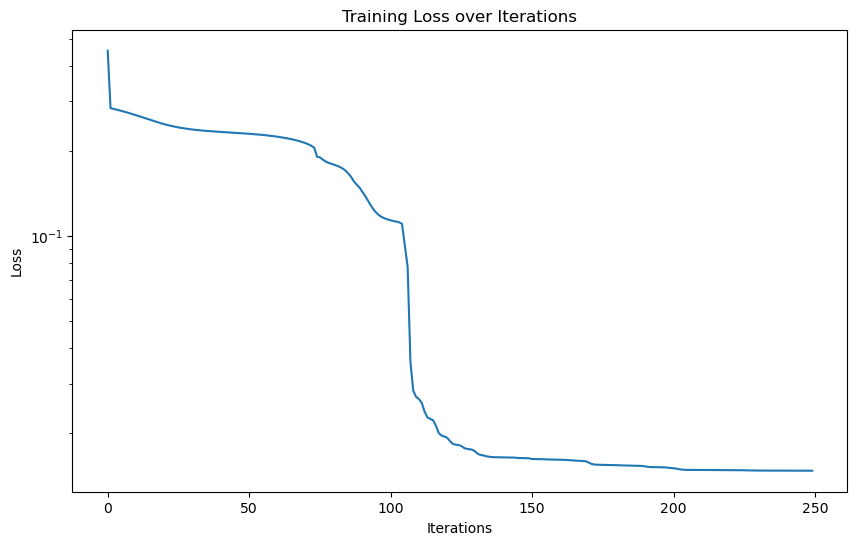

In [3]:
import numpy as np

class Layer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros((1, output_size))
        
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output
    
    def backward(self, grad_output):
        self.dweights = np.dot(self.inputs.T, grad_output)
        self.dbiases = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.layer1 = Layer(input_size, hidden_size)
        self.layer2 = Layer(hidden_size, output_size)
        
    def forward(self, x):
        self.h1 = relu(self.layer1.forward(x))
        self.y_pred = self.layer2.forward(self.h1)
        return self.y_pred
    
    def backward(self, grad_output):
        grad_h2 = self.layer2.backward(grad_output)
        grad_h1 = grad_h2 * relu_derivative(self.h1)
        self.layer1.backward(grad_h1)
        
    def get_params(self):
        return np.concatenate([self.layer1.weights.ravel(), self.layer1.biases.ravel(),
                               self.layer2.weights.ravel(), self.layer2.biases.ravel()])
    
    def set_params(self, params):
        idx = 0
        self.layer1.weights = params[idx:idx+self.layer1.weights.size].reshape(self.layer1.weights.shape)
        idx += self.layer1.weights.size
        self.layer1.biases = params[idx:idx+self.layer1.biases.size].reshape(self.layer1.biases.shape)
        idx += self.layer1.biases.size
        self.layer2.weights = params[idx:idx+self.layer2.weights.size].reshape(self.layer2.weights.shape)
        idx += self.layer2.weights.size
        self.layer2.biases = params[idx:idx+self.layer2.biases.size].reshape(self.layer2.biases.shape)

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

def f_alpha(alpha, fun, x, s, args):
    return fun(x + alpha * s, *args)

def search_golden_section(fun, dfun, x, s, args=(), delta=1.0e-2, tol=1e-15):
    gr = (np.sqrt(5) + 1) / 2
        
    AL = 0.
    FL = f_alpha(AL, fun, x, s, args)
    AA = delta
    FA = f_alpha(AA, fun, x, s, args)
    while FL < FA:
        delta = 0.1*delta
        AA = delta
        FA = f_alpha(AA, fun, x, s, args)
    
    j = 1
    AU = AA + delta * (gr**j)
    FU = f_alpha(AU, fun, x, s, args)
    while FA > FU:
        AL = AA
        AA = AU
        FL = FA
        FA = FU
        
        j += 1
        AU = AA + delta * (gr**j)
        FU = f_alpha(AU, fun, x, s, args)

    AB = AL + (AU - AL) / gr
    FB = f_alpha(AB, fun, x, s, args)
    
    while abs(AA - AB) > tol:
        if f_alpha(AA, fun, x, s, args) < f_alpha(AB, fun, x, s, args):
            AU = AB
        else:
            AL = AA

        AA = AU - (AU - AL) / gr
        AB = AL + (AU - AL) / gr

    return (AU + AL) / 2,

def objective(params, model, X, Y):
    model.set_params(params)
    y_pred = model.forward(X)
    return mse_loss(Y, y_pred)

def gradient(params, model, X, Y):
    model.set_params(params)
    y_pred = model.forward(X)
    grad_output = mse_derivative(Y, y_pred)
    model.backward(grad_output)
    return np.concatenate([model.layer1.dweights.ravel(), model.layer1.dbiases.ravel(),
                           model.layer2.dweights.ravel(), model.layer2.dbiases.ravel()])

def compute_conjugate_gradient(f, df, x, args=(), eps=1.0e-7, max_iter=2500, verbose=False, callback=None):
    if verbose:
        print("#####START OPTIMIZATION#####")
        print("INIT POINT : {}, dtype : {}".format(x, x.dtype))

    for k in range(max_iter):
        c = df(x, *args)
        if np.linalg.norm(c) < eps :
            if verbose:
                print("Stop criterion break Iter: {:5d}, x: {}".format(k, x))
                print("\n")
            break

        if k == 0 :
            d = -c
        else:
            beta = (np.linalg.norm(c) / np.linalg.norm(c_old))**2
            d = -c + beta*d
        
        alpha = search_golden_section(f, df, x, d, args=args)[0]
        x = x + alpha * d
        c_old = c.copy()    

        if callback :
            callback(x)    

    else:
        print("Stop max iter:{:5d} x:{}".format(k, x)) 

    return x

# 데이터 생성
np.random.seed(42)
t = np.linspace(0, 4*np.pi, 200)
y = np.sin(t) + 0.1 * np.random.randn(200)

# 시계열 데이터 준비
window_size = 5
X, Y = [], []
for i in range(len(y) - window_size):
    X.append(y[i:i+window_size])
    Y.append(y[i+window_size])
X, Y = np.array(X), np.array(Y).reshape(-1, 1)

# 학습 데이터와 테스트 데이터 분리
split = 150
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# 모델 초기화
model = MLP(window_size, 10, 1)

# 학습 과정을 기록하기 위한 리스트
losses = []

# 콜백 함수 정의
def callback(params):
    loss = objective(params, model, X_train, Y_train)
    losses.append(loss)
    if len(losses) % 100 == 0:
        print(f"Iteration {len(losses)}, Loss: {loss}")

# Conjugate Gradient 최적화
initial_params = model.get_params()
optimized_params = compute_conjugate_gradient(
    f=objective,
    df=gradient,
    x=initial_params,
    args=(model, X_train, Y_train),
    eps=1e-6,
    max_iter=250,
    verbose=True,
    callback=callback
)

# 최적화된 파라미터 설정
model.set_params(optimized_params)

# 45개의 새로운 데이터 포인트 예측
predictions = []
last_window = X_test[-1]

for _ in range(45):
    next_pred = model.forward(last_window.reshape(1, -1))
    predictions.append(next_pred[0, 0])
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_pred[0, 0]

print("45개의 예측된 데이터 포인트:", predictions)

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()